### Závěrečný projekt - modul Python

V tomto projektu budete analyzovat data ze stránky `www.sreality.cz`. Budete tedy získávat aktuální nabídku bytů ve Zlíně (či ve městě dle vašeho výběru)

## Důležité poznámky před začátkem:
- Mezi requesty vkládejte krátké pauzy (např. pomocí `time.sleep(1-2)`), abyste nezatěžovali server.
- **Struktura notebooku**: Váš notebook by měl být přehledně strukturovaný pomocí markdown buněk s nadpisy a komentářů v kódu, které vysvětlují vaše kroky.

## Projekt se dělí na 3 části:

### 1. WebScraping
Pomocí knihovny `BeautifulSoup` získejte **všechny aktuální inzerce bytů** v daném městě. 

**Poznámky:**
- Web scraping musí zahrnovat **všechny stránky** výsledků (pagination), ne pouze první stránku
- Získáte **tyto** informace: 
  - `URL odkaz bytu`
  - `Rozměry bytu` (v m²)
  - `Dispozice bytu` (1+1, 2+kk, atp.)
  - `Cena bytu` (v Kč)
  - `Lokace bytu` (Ulice + město)

**Očekávaný formát dat:**
- **Uložte surová data do CSV souboru** s názvem `{vašeJméno}_surova_data.csv` (tento soubor použijete v další části)

### 2. Datová analýza - ETL proces (Extract, Transform, Load)
V této fázi prověďte processing dat tak, aby obsahovala příslušné datové typy a byla připravená pro analýzu.

**Úkoly:**
- **Načtení dat:**
  - Načtěte surová data z CSV souboru `{vašeJméno}_surova_data.csv`, který jste vytvořili v části 1
  - Zobrazte základní informace o načtených datech (počet řádků, sloupců, náhled dat, datové typy)
  
- **Čištění dat:**
  - Ověřte a opravte datové typy (cena jako číselný typ, rozměry jako číselný typ)
  - Zpracujte chybějící hodnoty (rozhodněte se, zda je odstranit nebo nahradit, a zdůvodněte)
  - Rozdělte lokaci na samostatné sloupce: `Ulice` a `Město`
  
- **Export dat:**
  - Zprocesovaná a vyčištěná data vyexportujte do `.csv` souboru s názvem `{vašeJméno}_zdrojová_data.csv`
  - Před exportem zobrazte základní statistiku o vyčištěných datech (počet řádků, sloupců, základní statistiky)

### 3. Datová analýza - analýza dat
Třetí část začněte tak, že si do dataframe nahrajete vyčištěná data z CSV souboru `{vašeJméno}_zdrojová_data.csv`, který jste vytvořili v části 2.

**Analytické dotazy:**
1. `Jaká je průměrná cena bytů?` (uveďte i medián pro srovnání)
2. `Jaká je průměrná cena bytů pro každou dispozici (1+1, 2+1, atp.)? Zobrazte i na grafu.`
3. `Jaká je průměrná velikost bytu pro každou dispozici? Zobrazte i na grafu.`
4. `Existuje ulice, kde je vyšší koncentrace dražších bytů?` (Definujte "dražší" jako byty nad průměrnou cenou. Zobrazte top 5 ulic s nejvyšší průměrnou cenou, pokud máte dostatek dat.)
5. `Jaký typ dispozice je v daném městě nejčastěji inzerován? Který to je? Proč myslíte, že tomu tak je?` (Zobrazte na grafu - např. bar chart nebo pie chart)
6. `Existují zde inzerce bytů, které stojí více než 20.000,- Kč? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
7. `Zjištěte minimální a maximální cenu inzerce pro každou dispozici bytu. Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?` (Zobrazte i na grafu)

**Poznámky k analýze:**
- Všechny odpovědi doplňte komentáři a interpretací výsledků
- Pro vizualizace použijte `matplotlib` nebo `seaborn`
- Grafy by měly mít popisky os, titulky a být čitelné

## Odevzdání:
- Dotazy zodpovězte ve vašem pracovním notebooku s komentáři a interpretacemi
- Výsledný soubor nahrajte na GitHub
- V README na GitHubu uveďte stručný popis projektu a hlavní zjištění

## Tipy a užitečné knihovny

**Doporučené knihovny:**
```python
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
```

**Užitečné tipy:**
- Pro pagination: Zkontrolujte, jak stránka implementuje stránkování (URL parametr `?strana=X` nebo jiný mechanismus)
- Pro čištění dat: `pd.to_numeric()` s parametrem `errors='coerce'` pro konverzi cen a rozměrů
- Pro rozdělení lokace: `str.split()`

# WebScraping

In [1]:
from bs4 import BeautifulSoup
import re
import requests
import time

# Zapíšeme data do CSV souboru
with open('oravova_surova_data.csv', 'w') as soubor:
	soubor.write("url;rozmery;dispozice;cena;lokace\n")

	# Získáme všechny <li> prvky, které reprezentují stránky v zápatí stránky
	stranky = BeautifulSoup(requests.get('https://www.sreality.cz/hledani/pronajem/byty/zlin').text, 'html.parser').find('nav', attrs={'data-e2e':'pagination'}).find('ul').find_all('li', recursive=False)

	# Získáme číslo poslední stránky z posledního <li> prvku v seznamu
	pocet_stranek = int(stranky[len(stranky) - 1].find('a').get_text())

	# Projdeme všechny detekované stránky
	for strana in range(1, pocet_stranek + 1):
		time.sleep(1)

		# Získáme všechny odkazy na inzeráty na dané stránce
		inzeraty = BeautifulSoup(requests.get(f"https://www.sreality.cz/hledani/pronajem/byty/zlin?strana={strana}").text, 'html.parser').find('ul', attrs={'data-e2e':'estates-list'}).find_all('a', recursive=True)

		# Vytvoříme seznam URL inzerátů s vynecháním adresářových odkazů na makléře
		for inzerat in inzeraty:
			# Zpracujeme všechny inzeráty na aktuální stránce
			if (inzerat.get('href').startswith('/detail/')):
				time.sleep(1)

				url = 'https://www.sreality.cz' + inzerat.get('href')

				print(f'Zpracovávám inzerát "{url}"')

				inzerat = BeautifulSoup(requests.get(url).text, 'html.parser')

				# Vyčteme požadované informace ze záhlaví inzerátu s odstraněním nevhodných znaků
				detail = inzerat.find('h1', attrs={'data-e2e':'detail-heading'}).get_text().replace('\xa0', '')

				detaily = detail[: detail.find('m²')].split(' ')
				dispozice = detaily[2].strip()
				rozmery = detaily[3].strip()
				lokace = detail[detail.find('m²') + 2:].strip()

				cena_text = inzerat.find('p', attrs={'class': 'css-1b1ajfd'}).get_text().strip()

				# Ponecháme pouze čísla v ceně
				cena = re.sub("[^0-9]", "", cena_text)

				soubor.write(f"{url};{rozmery};{dispozice};{cena};{lokace}\n")


Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-devadesata/3612021580"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/2+kk/zlin-jaroslavice-v-doline/592909132"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/2+1/zlin-zlin-trida-tomase-bati/214295372"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/2+1/zlin-zlin-dlouha/1365844812"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-nad-stranemi/1328034636"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-j-a-bati/1357919052"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-j-a-bati/2892255820"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-breznicka/1564590924"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/1+1/zlin-malenovice-husova/3883602764"
Zpracovávám inzerát "https://www.sreality.cz/detail/pronajem/byt/2+1/zl

In [6]:
list_inzeratu = []

inzeraty_slovnik = {
    "Dispozice": dispozice,
    "Rozměry": rozmery,
    "Lokace": lokace,
    "Cena": cena
}

list_inzeratu.append(inzeraty_slovnik)

In [7]:
list_inzeratu

[{'Dispozice': '2+kk',
  'Rozměry': '47',
  'Lokace': 'K Luhám, Zlín - Louky',
  'Cena': '13900'}]

# ETL proces

In [10]:
# import CSV souboru
from pprint import pprint
import pandas as pd
df = pd.read_csv('oravova_surova_data.csv')
df.head()

,url;rozmery;dispozice;cena;lokace
https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-devadesata/3612021580;35;1+kk;12900;Devadesátá,Zlín
https://www.sreality.cz/detail/pronajem/byt/2+kk/zlin-jaroslavice-v-doline/592909132;45;2+kk;9500;V Dolině,Zlín - Jaroslavice
https://www.sreality.cz/detail/pronajem/byt/2+1/zlin-zlin-trida-tomase-bati/214295372;60;2+1;16000;třída Tomáše Bati,Zlín
https://www.sreality.cz/detail/pronajem/byt/2+1/zlin-zlin-dlouha/1365844812;56;2+1;13000;Dlouhá,Zlín
https://www.sreality.cz/detail/pronajem/byt/1+kk/zlin-zlin-nad-stranemi/1328034636;28;1+kk;10000;Nad Stráněmi,Zlín


In [ ]:
# rozdělení dat do sloupců

df_rozděleno = df = pd.read_csv('oravova_surova_data.csv', sep=";")
print(df)

# Tabulka má 5 sloupců a 218 řádků

                                                   url  rozmery dispozice  \
0    https://www.sreality.cz/detail/pronajem/byt/1+...       35      1+kk   
1    https://www.sreality.cz/detail/pronajem/byt/2+...       45      2+kk   
2    https://www.sreality.cz/detail/pronajem/byt/2+...       60       2+1   
3    https://www.sreality.cz/detail/pronajem/byt/2+...       56       2+1   
4    https://www.sreality.cz/detail/pronajem/byt/1+...       28      1+kk   
..                                                 ...      ...       ...   
214  https://www.sreality.cz/detail/pronajem/byt/1+...       27       1+1   
215  https://www.sreality.cz/detail/pronajem/byt/2+...       78       2+1   
216  https://www.sreality.cz/detail/pronajem/byt/3+...      143      3+kk   
217  https://www.sreality.cz/detail/pronajem/byt/1+...       23      1+kk   
218  https://www.sreality.cz/detail/pronajem/byt/2+...       47      2+kk   

        cena                            lokace  
0    12900.0              

In [31]:
df_rozděleno.head(20)

,url,rozmery,dispozice,cena,lokace
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12900.0,"Devadesátá, Zlín"
1,https://www.sreality.cz/detail/pronajem/byt/2+...,45,2+kk,9500.0,"V Dolině, Zlín - Jaroslavice"
2,https://www.sreality.cz/detail/pronajem/byt/2+...,60,2+1,16000.0,"třída Tomáše Bati, Zlín"
3,https://www.sreality.cz/detail/pronajem/byt/2+...,56,2+1,13000.0,"Dlouhá, Zlín"
4,https://www.sreality.cz/detail/pronajem/byt/1+...,28,1+kk,10000.0,"Nad Stráněmi, Zlín"
5,https://www.sreality.cz/detail/pronajem/byt/1+...,58,1+kk,NaN,"J. A. Bati, Zlín"
6,https://www.sreality.cz/detail/pronajem/byt/1+...,31,1+kk,NaN,"J. A. Bati, Zlín"
7,https://www.sreality.cz/detail/pronajem/byt/1+...,47,1+kk,12900.0,"Březnická, Zlín"
8,https://www.sreality.cz/detail/pronajem/byt/1+...,32,1+1,11000.0,"Husova, Zlín - Malenovice"
9,https://www.sreality.cz/detail/pronajem/byt/2+...,65,2+1,20000.0,"Mokrá II, Zlín - Mladcová"


In [ ]:
# Zobrazení datových typů ve sloupcích
df_rozděleno.info()

# Rozměry jsou datový typ Int64 - OK, číselný typ
# Cena je datový typ Float64 - OK, číselná hodnota s desetinnou tečkou

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        219 non-null    object 
 1   rozmery    219 non-null    int64  
 2   dispozice  219 non-null    object 
 3   cena       216 non-null    float64
 4   lokace     219 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.7+ KB


In [ ]:
# Zobrazení nulových / chybějících hodnot
df_rozděleno.loc[ df_rozděleno['rozmery'].isnull() ]

,url,rozmery,dispozice,cena,lokace


In [23]:
df_rozděleno.loc[ df_rozděleno['cena'].isnull() ]

,url,rozmery,dispozice,cena,lokace
5,https://www.sreality.cz/detail/pronajem/byt/1+...,58,1+kk,NaN,"J. A. Bati, Zlín"
6,https://www.sreality.cz/detail/pronajem/byt/1+...,31,1+kk,NaN,"J. A. Bati, Zlín"
44,https://www.sreality.cz/detail/pronajem/byt/4+...,130,4+1,NaN,"Pod Vrškem, Zlín"


In [24]:
df_rozděleno.loc[ df_rozděleno['dispozice'].isnull() ]

,url,rozmery,dispozice,cena,lokace


In [25]:
df_rozděleno.loc[ df_rozděleno['lokace'].isnull() ]

,url,rozmery,dispozice,cena,lokace


In [ ]:
# U 3 inzerátů chybí cena, jinak je dataset kompletní. Podíl chybějících dat je cca 1,4%, což je statisticky zanedbatelné. 
df_bez_nulovych = df_rozděleno.dropna(subset=['cena'])


In [ ]:
# Rozdělení sloupce Lokace do sloupců Ulice a Město
rozdelene = df['lokace'].str.split(',', n=1, expand=True)
rozdelene.columns = ['Ulice', 'Mesto']
df = df.join(rozdelene)

In [42]:
df.head(5)

,url,rozmery,dispozice,cena,lokace,Ulice,Mesto
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12900.0,"Devadesátá, Zlín",Devadesátá,Zlín
1,https://www.sreality.cz/detail/pronajem/byt/2+...,45,2+kk,9500.0,"V Dolině, Zlín - Jaroslavice",V Dolině,Zlín - Jaroslavice
2,https://www.sreality.cz/detail/pronajem/byt/2+...,60,2+1,16000.0,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
3,https://www.sreality.cz/detail/pronajem/byt/2+...,56,2+1,13000.0,"Dlouhá, Zlín",Dlouhá,Zlín
4,https://www.sreality.cz/detail/pronajem/byt/1+...,28,1+kk,10000.0,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín


In [ ]:
df_bez_nulovych = df.dropna(subset=['cena'])
# mazání 3 inzercí bez ceny

In [43]:
df_bez_nulovych.head(5)

,url,rozmery,dispozice,cena,lokace,Ulice,Mesto
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12900.0,"Devadesátá, Zlín",Devadesátá,Zlín
1,https://www.sreality.cz/detail/pronajem/byt/2+...,45,2+kk,9500.0,"V Dolině, Zlín - Jaroslavice",V Dolině,Zlín - Jaroslavice
2,https://www.sreality.cz/detail/pronajem/byt/2+...,60,2+1,16000.0,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
3,https://www.sreality.cz/detail/pronajem/byt/2+...,56,2+1,13000.0,"Dlouhá, Zlín",Dlouhá,Zlín
4,https://www.sreality.cz/detail/pronajem/byt/1+...,28,1+kk,10000.0,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín


In [ ]:
df_bez_nulovych.loc[ df_bez_nulovych['cena'].isnull() ]
# kontrola nulových hodnot ve sloupci cena

,url,rozmery,dispozice,cena,lokace,Ulice,Mesto


In [45]:
df_bez_nulovych.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 0 to 218
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        216 non-null    object 
 1   rozmery    216 non-null    int64  
 2   dispozice  216 non-null    object 
 3   cena       216 non-null    float64
 4   lokace     216 non-null    object 
 5   Ulice      216 non-null    object 
 6   Mesto      198 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 13.5+ KB


In [46]:
# Export df do CSV souboru
df_bez_nulovych.to_csv("Oravova_zdrojova_data.csv", index=False)

# Datová analýza

In [67]:
# Import knihoven pro vizualizaci dat
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
df = pd.read_csv('Oravova_zdrojova_data.csv')
df.head()

,url,rozmery,dispozice,cena,lokace,Ulice,Mesto
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12900.0,"Devadesátá, Zlín",Devadesátá,Zlín
1,https://www.sreality.cz/detail/pronajem/byt/2+...,45,2+kk,9500.0,"V Dolině, Zlín - Jaroslavice",V Dolině,Zlín - Jaroslavice
2,https://www.sreality.cz/detail/pronajem/byt/2+...,60,2+1,16000.0,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
3,https://www.sreality.cz/detail/pronajem/byt/2+...,56,2+1,13000.0,"Dlouhá, Zlín",Dlouhá,Zlín
4,https://www.sreality.cz/detail/pronajem/byt/1+...,28,1+kk,10000.0,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín


In [56]:
# 1. Jaká je průměrná cena bytů? (uveďte i medián pro srovnání)
prumer_cena = df['cena'].mean()
print(prumer_cena)
print(f"Průměrná cena pronájmu je {prumer_cena:.0f} Kč")

15067.0
Průměrná cena pronájmu je 15067 Kč


In [ ]:
# Medián cen pronájmů
median_cen = df['cena'].median()
print(median_cen)
print(f"Medián cen je {median_cen:.0f} Kč")

14000.0
Medián cen je 14000 Kč


In [ ]:
# 2. Jaká je průměrná cena bytů pro každou dispozici (1+1, 2+1, atp.)? Zobrazte i na grafu.

df.groupby('dispozice')['cena'].mean().reset_index(name="Průměrná cena bytů dle dispozice").round(0)

,dispozice,Průměrná cena bytů dle dispozice
0,1+1,12503.0
1,1+kk,11731.0
2,2+1,14663.0
3,2+kk,16126.0
4,3+1,17810.0
5,3+kk,21320.0
6,4+1,17300.0
7,4+kk,23167.0
8,pokoje,6250.0


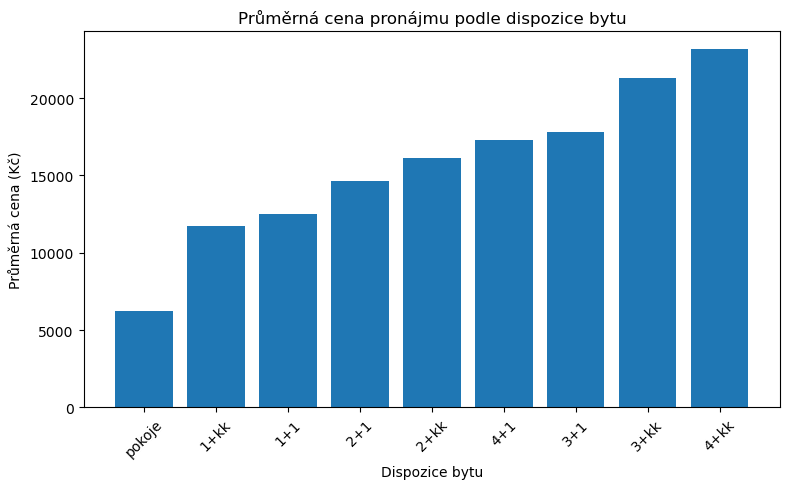

In [ ]:
# Vytvoření grafu - průměrná cena dle dispozice
prumerne_ceny = df.groupby('dispozice')['cena'].mean().sort_values()

plt.figure(figsize=(8, 5))
plt.bar(prumerne_ceny.index, prumerne_ceny.values)
plt.xlabel('Dispozice bytu')
plt.ylabel('Průměrná cena (Kč)')
plt.title('Průměrná cena pronájmu podle dispozice bytu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Z grafu je vidět, že největší byty (4+kk, 3+kk) jsou logicky nejdražší. 

In [ ]:
# 3. Jaká je průměrná velikost bytu pro každou dispozici? Zobrazte i na grafu.

df.groupby('dispozice')['rozmery'].mean().reset_index(name="Průměrná velikost bytu dle dispozice").round(2)

,dispozice,Průměrná velikost bytu dle dispozice
0,1+1,36.55
1,1+kk,33.24
2,2+1,60.47
3,2+kk,55.40
4,3+1,71.05
5,3+kk,87.24
6,4+1,84.67
7,4+kk,104.00
8,pokoje,80.25


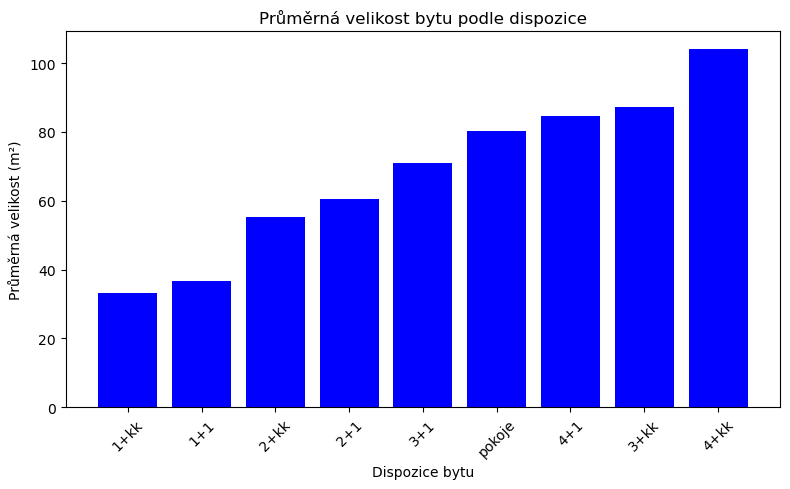

In [ ]:
# Vytvoření grafu - průměrná velikost dle dispozice
prumerne_velikosti = df.groupby('dispozice')['rozmery'].mean().sort_values()

plt.figure(figsize=(8, 5))
plt.bar(prumerne_velikosti.index, prumerne_velikosti.values, color='blue')
plt.xlabel('Dispozice bytu')
plt.ylabel('Průměrná velikost (m²)')
plt.title('Průměrná velikost bytu podle dispozice')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Existuje ulice, kde je vyšší koncentrace dražších bytů? 
# Definujte "dražší" jako byty nad průměrnou cenou. 
# Zobrazte top 5 ulic s nejvyšší průměrnou cenou, pokud máte dostatek dat.

drazsi_ulice = df.groupby('Ulice')['cena'].mean().loc[lambda x: x > 15067].sort_values(ascending=False).round(0)

print(f"Top 5 ulic s nejvyšší průměrnou cenou:")
print(drazsi_ulice.head())

print(f"\nCelkem {len(drazsi_ulice)} ulic má průměrnou cenu nad celkovým průměrem ({prumer_cena} Kč)")

Top 5 ulic s nejvyšší průměrnou cenou:
Ulice
Sýkory II              29000.0
Jarolímkovo náměstí    25000.0
Kpt. Nálepky           24000.0
Havlíčkovo nábřeží     23500.0
Mostní                 23333.0
Name: cena, dtype: float64

Celkem 46 ulic má průměrnou cenu nad celkovým průměrem (15067.0 Kč)


In [76]:
# 5. Jaký typ dispozice je v daném městě nejčastěji inzerován? 
# Který to je? Proč myslíte, že tomu tak je?

pocet_dispozic = df['dispozice'].value_counts()
print(pocet_dispozic)
print(f"\nNejčastější dispozice je: {pocet_dispozic.index[0]} s počtem {pocet_dispozic.values[0]} inzerátů")

dispozice
1+kk      49
2+kk      47
2+1       34
1+1       31
3+kk      25
3+1       20
pokoje     4
4+1        3
4+kk       3
Name: count, dtype: int64

Nejčastější dispozice je: 1+kk s počtem 49 inzerátů


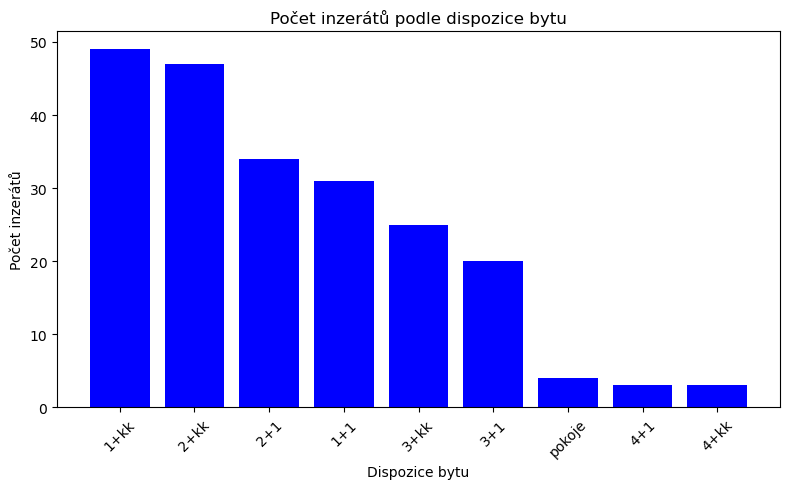

In [ ]:
# Graf - četnost dispozic
plt.figure(figsize=(8, 5))
plt.bar(pocet_dispozic.index, pocet_dispozic.values, color='blue')
plt.xlabel('Dispozice bytu')
plt.ylabel('Počet inzerátů')
plt.title('Počet inzerátů podle dispozice bytu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Nejčastější dispozice je 1+kk a 2+kk.
# Jedná se o byty optimální velikosti pro single populaci, bezdětné mladé páry nebo malé rodiny, ale také pro stárnoucí generaci (bezbariérové bydlení)
# Tyto byty jsou pronajímány za levnější cenu a jsou také levnější na provoz.
# Pro investory mají vyšší návratnost, snadněji se pronajímají.
# Ve městech lidé tráví v bytech méně času (práce, kultura)

In [80]:
# 6. Existují zde inzerce bytů, které stojí více než 20.000,- Kč? 
# Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?

byty_nad_20k = df[df['cena'] > 20000]
print(f"Počet bytů s cenou nad 20 000 Kč: {len(byty_nad_20k)}")
print(f"\nDispozice bytů nad 20 000 Kč:")
print(byty_nad_20k['dispozice'].value_counts())

Počet bytů s cenou nad 20 000 Kč: 21

Dispozice bytů nad 20 000 Kč:
dispozice
3+kk    12
3+1      4
2+kk     3
2+1      1
4+kk     1
Name: count, dtype: int64


In [81]:
# Kontrola dvoupokojových bytů nad 20 000 Kč
dvoupokojove_nad_20k = byty_nad_20k[byty_nad_20k['dispozice'].isin(['2+1', '2+kk'])]
print(f"Počet dvoupokojových bytů (2+1/2+kk) nad 20 000 Kč: {len(dvoupokojove_nad_20k)}")

if len(dvoupokojove_nad_20k) > 0:
    print("\nAno, v cenové hladině nad 20 000 Kč jsou inzerovány i dvoupokojové byty.")
    print("Jedná se pravděpodobně o luxusní byty v prestižních lokalitách nebo nové byty.")
else:
    print("\nNe, dvoupokojové byty (2+1/2+kk) nejsou v této cenové hladině inzerovány.")

Počet dvoupokojových bytů (2+1/2+kk) nad 20 000 Kč: 4

Ano, v cenové hladině nad 20 000 Kč jsou inzerovány i dvoupokojové byty.
Jedná se pravděpodobně o luxusní byty v prestižních lokalitách nebo nové byty.


In [83]:
# 7. Zjištěte minimální a maximální cenu inzerce pro každou dispozici bytu. 
# Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?

# Výpočet min a max ceny pro každou dispozici
min_ceny = df.groupby('dispozice')['cena'].min()
max_ceny = df.groupby('dispozice')['cena'].max()

# Vytvoření DataFrame se statistikami
statistiky_cen = pd.DataFrame({
    'min': min_ceny,
    'max': max_ceny
})

# Výpočet rozptylu
statistiky_cen['rozptyl'] = statistiky_cen['max'] - statistiky_cen['min']

# Seřazení podle rozptylu
statistiky_cen = statistiky_cen.sort_values('rozptyl', ascending=False)

print(statistiky_cen)
print(f"\nNejvětší rozptyl má dispozice: {statistiky_cen.index[0]}")
print(f"Rozptyl: {statistiky_cen['rozptyl'].iloc[0]:.0f} Kč (min: {statistiky_cen['min'].iloc[0]:.0f} Kč, max: {statistiky_cen['max'].iloc[0]:.0f} Kč)")

               min      max  rozptyl
dispozice                           
3+kk       12500.0  33000.0  20500.0
4+kk       17500.0  33000.0  15500.0
2+kk        9500.0  25000.0  15500.0
3+1        12500.0  26000.0  13500.0
2+1        11000.0  20500.0   9500.0
1+1         9500.0  16500.0   7000.0
1+kk        8000.0  14900.0   6900.0
4+1        15000.0  19900.0   4900.0
pokoje      5000.0   7500.0   2500.0

Největší rozptyl má dispozice: 3+kk
Rozptyl: 20500 Kč (min: 12500 Kč, max: 33000 Kč)


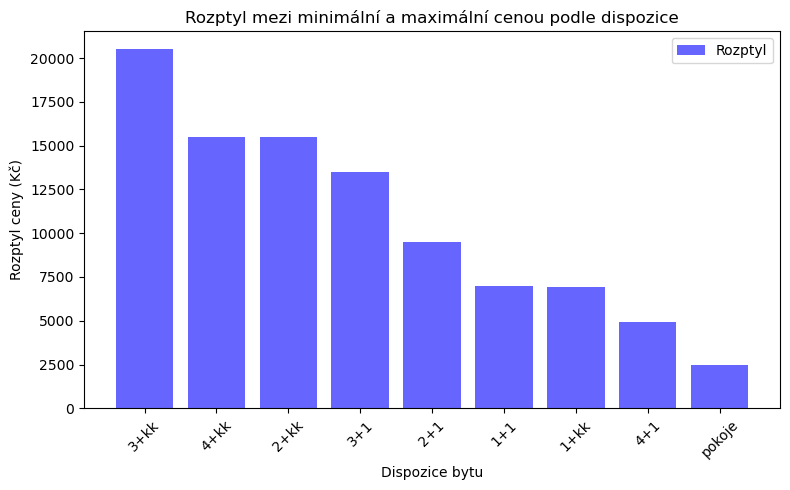

In [ ]:
# Graf - rozptyl cen podle dispozice
plt.figure(figsize=(8, 5))
x = range(len(statistiky_cen))
plt.bar(x, statistiky_cen['rozptyl'], color='blue', alpha=0.6, label='Rozptyl')
plt.xticks(x, statistiky_cen.index, rotation=45)
plt.xlabel('Dispozice bytu')
plt.ylabel('Rozptyl ceny (Kč)')
plt.title('Rozptyl mezi minimální a maximální cenou podle dispozice')
plt.legend()
plt.tight_layout()
plt.show()

# Největší rozptyl mají dispozice 3+kk a 4+kk.
# U těchto dispozic existují jak levné standardní byty, tak luxusní varianty v "lepších" lokalitách.